# Implementation of ELAINE

_Goyal P, Hosseinmardi H, Ferrara E, et al. Capturing Edge Attributes via Network Embedding[J]._ arXiv preprint arXiv:1805.03280, 2018.

# Introduce of Variational Autoencoder 

> Codes in this section are from [Variational Autoencoder in TensorFlow](https://jmetzen.github.io/2015-11-27/vae.html).
>
> For a better understanding of VAE, please refer to paper _[Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)_

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import normalize
import os

# np.random.seed(0)
# tf.set_random_seed(0)

## MNIST dataset

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Definition of VAE class

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [5]:
def xavier_init(fan_in, fan_out, constant=1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)


class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.

    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.

    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """

    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=100, beta=0.5):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.beta = beta

        # tf Graph input
        self.x = tf.placeholder(
            tf.float32, [None, network_architecture["n_input"]])

        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)

    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"],
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1,
                               dtype=tf.float32)
        # z = mu + sigma*epsilon, `*` represents element-wise product.
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])

    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2,
                            n_hidden_gener_1,  n_hidden_gener_2,
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights

    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']),
                                           biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                           biases['b2']))
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']),
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),
                                           biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                           biases['b2']))
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']),
                                 biases['out_mean']))
        return x_reconstr_mean

    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-6 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-6 + 1 - self.x_reconstr_mean), 1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence
        # between the distribution in latent space induced by the encoder on
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -self.beta * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(
            reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(
                learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run((self.z, self.z_mean), feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.

        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})

## Training on MNIST dataset

In [6]:
def train(network_architecture, learning_rate=0.001,
          batch_size=1000, training_epochs=10, display_step=5, beta=0.5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size,
                                 beta=beta)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [7]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=250, # 2nd layer encoder neurons
         n_hidden_gener_1=250, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space
    
vae = train(network_architecture, training_epochs=50, beta=0.5)

Epoch: 0001 cost= 231.055453769
Epoch: 0006 cost= 176.790720992
Epoch: 0011 cost= 165.946765692
Epoch: 0016 cost= 161.846789551
Epoch: 0021 cost= 158.010741355
Epoch: 0026 cost= 155.460339910
Epoch: 0031 cost= 153.662526079
Epoch: 0036 cost= 151.995467862
Epoch: 0041 cost= 150.511937089
Epoch: 0046 cost= 149.275061867


## VAE reconstruction

In [8]:
import matplotlib.pyplot as plt

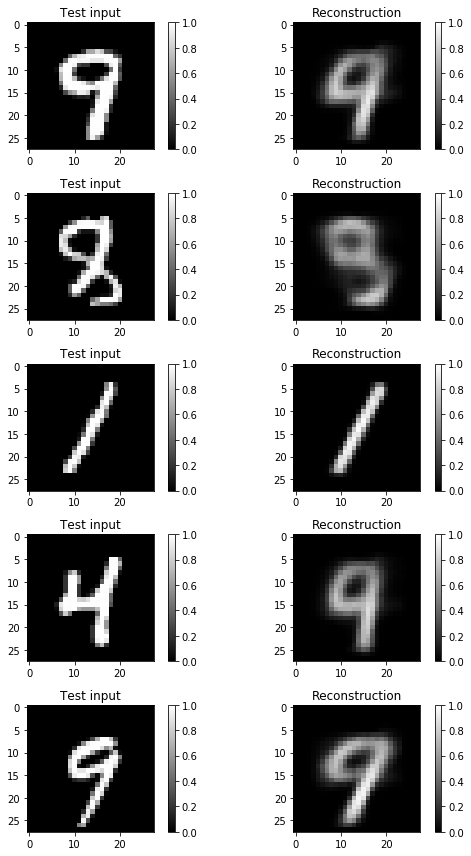

In [10]:
x_sample = mnist.test.next_batch(1000)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()
plt.show()

## Illustrating latent space

### Generate data using latent values

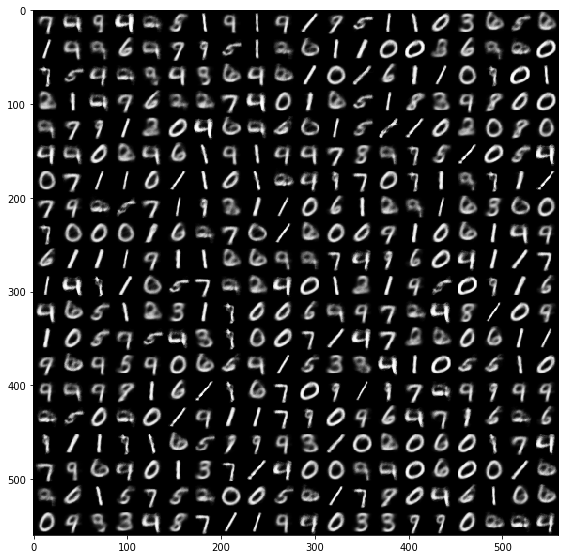

In [11]:
nx = ny = 20

canvas = np.empty((28*ny, 28*nx))
for i in range(nx):
    for j in range(ny):
        input_vector = np.random.random_sample((2)) * 6 - 3
        z_mu = np.array([input_vector]*vae.batch_size)
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()
plt.show()

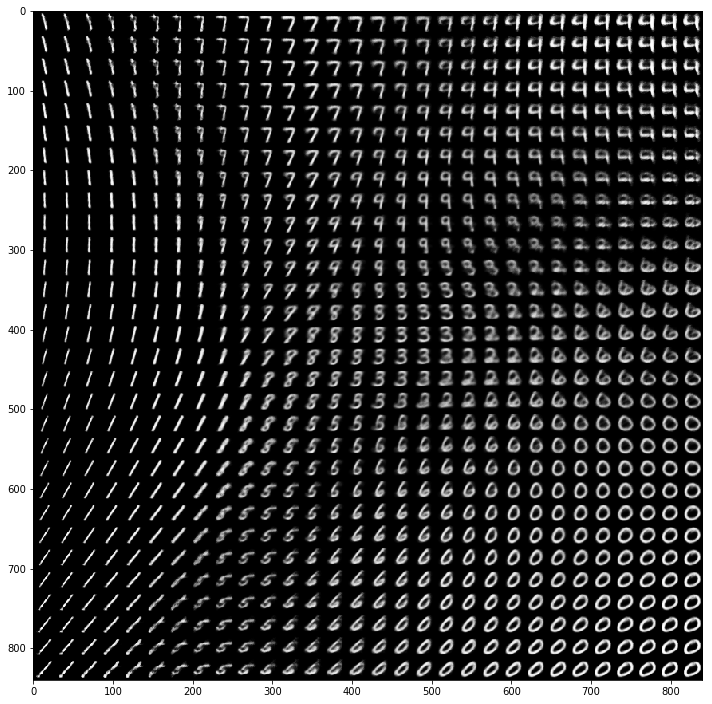

In [12]:
nx = ny = 30
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(10, 12))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

### Illustrate 2-dimensional latent space

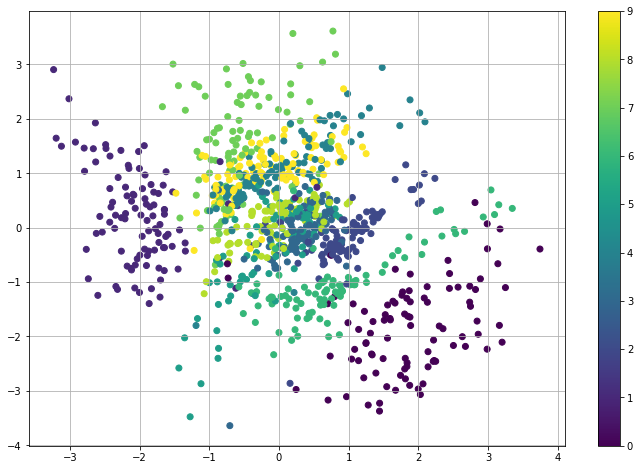

In [13]:
x_sample, y_sample = mnist.test.next_batch(1000)
_, z_mu = vae.transform(x_sample)
plt.figure(figsize=(12, 8)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

# Build graph structure

In [ ]:
import os
import pickle
import networkx as nx
import pandas as pd
import utils

## Load O-D set and K-Means

In [ ]:
with open(os.path.join('data', 'chengdu', 'od_20161001.pkl'), 'rb') as od_file:
    od_set = pickle.load(od_file)
with open('model/kmeans.pkl', 'rb') as kmeans_file:
    kmeans = pickle.load(kmeans_file)

In [ ]:
od_set_label = pd.DataFrame(od_set, copy=True)
od_set_label['cluster'] = kmeans.predict(od_set[['longitude', 'latitude']])

## Construct graph

In [ ]:
graph = nx.DiGraph()
utils.add_dataset_to_graph(od_set_label, graph)

In [ ]:
slot_graph = nx.DiGraph()
utils.add_timeslot_weight_to_graph(od_set_label, slot_graph)

In [ ]:
with open('data/chengdu/graph/g_20161001.pkl', 'rb') as g_file:
    graph = pickle.load(g_file)
with open('data/chengdu/graph/sg_20161001.pkl', 'rb') as sg_file:
    slot_graph = pickle.load(sg_file)

# Implementation of random walk

In [ ]:
from node2vec import Node2Vec

In [ ]:
node2vec_class = Node2Vec(graph, dimensions=10, walk_length=8, num_walks=1600, weight_key='weight')
n2v = node2vec_class.fit(window=8, min_count=1, batch_words=8)

# Definition of graph data

Assume that there are $n$ nodes, $m$ edges, every node have $p$ attributes, and every edge have $q$ attributes.
For every node, we fetch its $k$ nearest neighbors.

In [ ]:
NODE_NUM = len(graph.nodes())
NEIGHBOR_NUM = 4

## Edge attributes matrix $E\in \mathbb R^{m\times q}$

In this implementation, edge attributes are weight list from slot graph.

In [ ]:
edge_attr = dict()
for start, end in slot_graph.edges():
    edge_attr[(start, end)] = slot_graph[start][end]['weight']

In [ ]:
edge_attr_matrix = pd.DataFrame(edge_attr).T
edge_attr_matrix = edge_attr_matrix.sample(frac=1).astype(np.float32)

In [ ]:
edge_attr_norm = pd.DataFrame(normalize(edge_attr_matrix, norm='max'))
edge_attr_norm.index = edge_attr_matrix.index

## Node attributes matrix $N\in \mathbb R^{n\times p}$

Currently, we define node attributes as their rows in the adjacency matrix.

In [ ]:
node_attr = dict()
for i in range(NODE_NUM):
    row = []
    for j in range(NODE_NUM):
        try:
            weight = graph[i][j]['weight']
        except KeyError:
            weight = 0
        row.append(weight)
    node_attr[i] = row

In [ ]:
node_attr_matrix = pd.DataFrame(node_attr).T
node_attr_matrix = node_attr_matrix.sort_index().astype(np.float32)

In [ ]:
node_attr_norm = pd.DataFrame(normalize(node_attr_matrix, norm='max'))
node_attr_norm.index = node_attr_matrix.index


## Neighborhood matrix $F\in \mathbb R^{n\times (p*(k+1))}$

Every row of neighborhood matrix consists of the correspond node's attribute and its $k$ nearest neighbors' attributes.

In [ ]:
neig = []
for i in range(NODE_NUM):
    row = [node_attr_matrix[i]]
    for j in range(NEIGHBOR_NUM):
        near_row = n2v.wv.most_similar(str(i))[j]
        near_node = int(near_row[0])
        row.append(node_attr_matrix.loc[near_node])
    row_series = pd.concat(row)
    row_series.index = range(row_series.shape[0])
    neig.append(row_series)

In [ ]:
neig_matrix = pd.DataFrame(neig)

In [ ]:
neig_norm = pd.DataFrame(normalize(neig_matrix, norm='max'))
neig_norm.index = neig_matrix.index

# ELAINE algorithm

## Definition of network architecture

### xavier Initializer

In [ ]:
def xavier_init(fan_in, fan_out, constant=1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

### Variational encoder and decoder

`z_mean` and `z_log_sigma_sq` correspond to $\mu$ and $\sigma$ in Gaussian distribution.

In [ ]:
def encoder(input_x, weights, biases, fc_activation, out_mean, out_log_sigma):
    """
    VAE encoder. The length of List `weights` and `biases` indicates
    the depth of FC layer in this encoder.
    Maps inputs onto a normal distribution in latent space.
    The transformation is parameterized and can be learned.
    
    @params input_x: Input tensor.
    @params weights: List of FC layer weights.
    @params biases: List of FC layer biases.
    @params fc_activation: Activation function for FC layers.
    @params out_mean: Dict in format {'weight': out_mean_weight, 'bias': out_mean_bias}
    @params out_log_sigma: Dict in format {'weight': out_log_sigma_weight, 'bias': out_log_sigma_bias}
    """
    current_layer = input_x
    for weight, bias in zip(weights, biases):
        current_layer = fc_activation(tf.add(tf.matmul(current_layer, weight), bias))
    z_mean = tf.add(tf.matmul(current_layer, out_mean['weight']), out_mean['bias'])
    z_log_sigma_sq = tf.add(tf.matmul(current_layer, out_log_sigma['weight']), out_log_sigma['bias'])
    return (z_mean, z_log_sigma_sq)

In [ ]:
def decoder(input_z, weights, biases, fc_activation, out_mean):
    """
    VAE decoder. The length of List `weights` and `biases` indicated
    the depth of the FC layer in this decoder.
    Maps points in latent space onto a Bernoulli distribution in data space.
    The transformation is parameterized and can be learned.
    
    @params input_z: Input tensor sampled from Gaussian distribution.
    @params weights: List of FC layer weights.
    @params biases: List of FC layer biases.
    @params fc_activation: Activation function for FC layers.
    @params out_mean: Dict in format {'weight': out_mean_weight, 'bias': out_mean_bias}
    """
    layers = []
    current_layer = input_z
    for weight, bias in zip(weights, biases):
        current_layer = fc_activation(tf.add(tf.matmul(current_layer, weight), bias))
        layers.append(current_layer)
    x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(current_layer, out_mean['weight']), out_mean['bias']))
    return x_reconstr_mean

### Define model parameters

In [ ]:
# Encoder constants
ENCODER_INPUT_LENGTH = neig_matrix.shape[1]  # Single encoder input tensor length. Current: 2000
ENCODER_SIZES = [ENCODER_INPUT_LENGTH, 1024, 512, 256, 128]  # Sizes of each layer in encoder FC part.
LATENT_SIZE = 32  # Size of latent space, also the length of encoder output.
ENCODER_DEPTH = len(ENCODER_SIZES)

# Single decoder constants
SINGLE_DECODER_INPUT_LENGTH = LATENT_SIZE
SINGLE_DECODER_SIZES = [SINGLE_DECODER_INPUT_LENGTH, 128, 256, 512, 1024]  # Size of each layer in single decoder FC part.
SINGLE_DECODER_OUTPUT_LENGTH = ENCODER_INPUT_LENGTH
SINGLE_DECODER_DEPTH = len(SINGLE_DECODER_SIZES)

# Double decoder constants
DOUBLE_DECODER_INPUT_LENGTH = LATENT_SIZE * 2
DOUBLE_DECODER_SIZES = [DOUBLE_DECODER_INPUT_LENGTH, 64, 32]  # Sizes of each layer in double decoder FC part.
DOUBLE_DECODER_OUTPUT_LENGTH = edge_attr_matrix.shape[1]
DOUBLE_DECODER_DEPTH = len(DOUBLE_DECODER_SIZES)

# Basic model parameters
BATCH_SIZE = 50
LEARNING_RATE = 0.001
TRAINING_EPOCHS = 100

NODE_ATTR_LOSS_WEIGHT = 1
LATENT_LOSS_WEIGHT = 0.01
EDGE_ATTR_LOSS_WEIGHT = 0.5

## Fetch graph data in a batch style

In [ ]:
def next_batch(edge_attr, batch_size, steps):
    """
    Fetch next batch graph data.
    """
    edge_count = edge_attr.shape[0]
    
    start = steps*batch_size % edge_count
    end = (steps+1)*batch_size % edge_count
    
    if start > end:
        result = pd.concat([edge_attr.iloc[start:], edge_attr.iloc[:end]])
    else:
        result = edge_attr.iloc[start:end]
    return result

## Merge everything into final model

The core structure of ELAINE:
![structure.png](image/structure.png)

In [ ]:
class ELAINE:
    """
    Implementation of ELAINE model.
    Paper: Goyal P, Hosseinmardi H, Ferrara E, et al. Capturing Edge Attributes via Network Embedding[J]. 
    arXiv preprint arXiv:1805.03280, 2018.
    """

    def __init__(self, batch_size, learning_rate):
        tf.reset_default_graph()
        # Get encoder and decoders' initial parameters.
        self._init_params()

        # Input placeholder for "left encoder" and "right encoder"
        with tf.variable_scope('input'):
            self.l_node_input = tf.placeholder(dtype=tf.float32,
                                               shape=[None, ENCODER_INPUT_LENGTH], name='l_node')
            self.r_node_input = tf.placeholder(dtype=tf.float32,
                                               shape=[None, ENCODER_INPUT_LENGTH], name='r_node')

            self.edge_attr = tf.placeholder(dtype=tf.float32,
                                            shape=[None, DOUBLE_DECODER_OUTPUT_LENGTH], name='edge')

        # Assign learning rate and batch size.
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Build network structure.
        self._create_network()
        # Create loss tensor and optimize operation.
        self._create_loss_optimizer()

        # Run gloabal variables initializer.
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def _create_network(self):
        """
        Build up network structure.
        """
        # Feed "left" and "right" node attribute matrixes into variational encoder.
        # Use encoder to determine mean and variance of Gaussian distribution in latent space.
        self.l_z_mean, self.l_z_log_sigma_sq = encoder(self.l_node_input,
                                                       self.e_p['weights'], self.e_p['biases'],
                                                       self.e_p['fc_activation'], self.e_p['out_mean'],
                                                       self.e_p['out_log_sigma'])
        self.r_z_mean, self.r_z_log_sigma_sq = encoder(self.r_node_input,
                                                       self.e_p['weights'], self.e_p['biases'],
                                                       self.e_p['fc_activation'], self.e_p['out_mean'],
                                                       self.e_p['out_log_sigma'])

        # Draw one sample form Gaussian distribution.
        l_eps = tf.random_normal(
            (self.batch_size, LATENT_SIZE), 0, 1, dtype=tf.float32)
        r_eps = tf.random_normal(
            (self.batch_size, LATENT_SIZE), 0, 1, dtype=tf.float32)
        # z = mu = sigma * epsilon
        l_z = tf.add(self.l_z_mean, tf.multiply(
            tf.sqrt(tf.exp(self.l_z_log_sigma_sq)), l_eps))
        r_z = tf.add(self.r_z_mean, tf.multiply(
            tf.sqrt(tf.exp(self.r_z_log_sigma_sq)), r_eps))

        # Use decoder to determine mean of Bernoulli distribution of reconstructed input.
        self.l_reconstr_mean = decoder(l_z,
                                       self.s_d_p['weights'], self.s_d_p['biases'],
                                       self.s_d_p['fc_activation'], self.s_d_p['out_mean'])
        self.r_reconstr_mean = decoder(r_z,
                                       self.s_d_p['weights'], self.s_d_p['biases'],
                                       self.s_d_p['fc_activation'], self.s_d_p['out_mean'])

        # Concatenate "left" and "right" encoder's result into matrix doubled the width.
        # The matrix is feeded into decoder and used to reconstruct edge attributes.
        edge_input = tf.concat([l_z, r_z], -1)
        self.edge_reconstr_mean = decoder(edge_input,
                                          self.d_d_p['weights'], self.d_d_p['biases'],
                                          self.d_d_p['fc_activation'], self.d_d_p['out_mean'])

    def _create_loss_optimizer(self):
        """
        Calculate nodes and labels' reconstruction losses and latent losses,
        then combine them into final loss.
        """
        l_reconstr_loss = -tf.reduce_sum(self.l_node_input * tf.log(1e-10 + self.l_reconstr_mean)
                                         + (1-self.l_node_input) *
                                         tf.log(1e-10 + 1 - self.l_reconstr_mean), 1)
        r_reconstr_loss = -tf.reduce_sum(self.r_node_input * tf.log(1e-10 + self.r_reconstr_mean)
                                         + (1-self.r_node_input) *
                                         tf.log(1e-10 + 1 - self.r_reconstr_mean), 1)

        l_latent_loss = -tf.reduce_sum(1 + self.l_z_log_sigma_sq
                                       - tf.square(self.l_z_mean)
                                       - tf.exp(self.l_z_log_sigma_sq), 1)
        r_latent_loss = -tf.reduce_sum(1 + self.r_z_log_sigma_sq
                                       - tf.square(self.r_z_mean)
                                       - tf.exp(self.r_z_log_sigma_sq), 1)

        edge_reconstr_loss = -tf.reduce_sum(self.edge_attr * tf.log(1e-10 + self.edge_reconstr_mean)
                                            + (1-self.edge_attr) *
                                            tf.log(1e-10 + 1 - self.edge_reconstr_mean), 1)

        self.cost = \
            NODE_ATTR_LOSS_WEIGHT * tf.reduce_sum(0.5 * l_reconstr_loss + 0.5 * r_reconstr_loss) + \
            LATENT_LOSS_WEIGHT * tf.reduce_sum(0.5 * l_latent_loss + 0.5 * r_latent_loss) + \
            EDGE_ATTR_LOSS_WEIGHT * tf.reduce_sum(edge_reconstr_loss)
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, edge_batch):
        """
        Fit a batch of edge attribute matrix.
        """
        l_node_attrs, r_node_attrs, edge_attrs = [], [], []
        for node_pair, edge_attr in edge_batch.iterrows():
            l_node = node_pair[0]
            r_node = node_pair[1]

            l_node_attrs.append(neig_norm.loc[l_node])
            r_node_attrs.append(neig_norm.loc[r_node])

            edge_attrs.append(edge_attr)
        l_node_attrs = np.array(l_node_attrs)
        r_node_attrs = np.array(r_node_attrs)
        edge_attrs = np.array(edge_attrs)

        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.l_node_input: l_node_attrs,
                                             self.r_node_input: r_node_attrs,
                                             self.edge_attr: edge_attrs})
        return cost

    def transform(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        return self.sess.run(self.l_z_mean, feed_dict={self.l_node_input: X})

    def _init_params(self):
        with tf.variable_scope('encoder'):
            self.e_p = dict(
                weights=[tf.Variable(xavier_init(ENCODER_SIZES[i], ENCODER_SIZES[i+1]),
                                     name='weight_{}'.format(i))
                         for i in range(ENCODER_DEPTH-1)],
                biases=[tf.Variable(tf.zeros([ENCODER_SIZES[i+1]], dtype=tf.float32),
                                    name='bias_{}'.format(i))
                        for i in range(ENCODER_DEPTH-1)],
                fc_activation=tf.nn.softplus,
                out_mean=dict(
                    weight=tf.Variable(xavier_init(ENCODER_SIZES[-1], LATENT_SIZE),
                                       name='out_mean_weight'),
                    bias=tf.Variable(tf.zeros([LATENT_SIZE], dtype=tf.float32),
                                     name='out_mean_bias')
                ),
                out_log_sigma=dict(
                    weight=tf.Variable(xavier_init(ENCODER_SIZES[-1], LATENT_SIZE),
                                       name='out_log_sigma_weight'),
                    bias=tf.Variable(tf.zeros([LATENT_SIZE], dtype=tf.float32),
                                     name='out_mean_bias')
                )
            )
        with tf.variable_scope('s-decoder'):
            self.s_d_p = dict(
                weights=[tf.Variable(xavier_init(SINGLE_DECODER_SIZES[i], SINGLE_DECODER_SIZES[i+1]),
                                     name='weight_{}'.format(i))
                         for i in range(SINGLE_DECODER_DEPTH-1)],
                biases=[tf.Variable(tf.zeros([SINGLE_DECODER_SIZES[i+1]], dtype=tf.float32),
                                    name='bias_{}'.format(i))
                        for i in range(SINGLE_DECODER_DEPTH-1)],
                fc_activation=tf.nn.softplus,
                out_mean=dict(
                    weight=tf.Variable(xavier_init(SINGLE_DECODER_SIZES[-1], SINGLE_DECODER_OUTPUT_LENGTH),
                                       name='out_mean_weight'),
                    bias=tf.Variable(tf.zeros([SINGLE_DECODER_OUTPUT_LENGTH], dtype=tf.float32),
                                     name='out_mean_bias')
                )
            )
        with tf.variable_scope('d-decoder'):
            self.d_d_p = dict(
                weights=[tf.Variable(xavier_init(DOUBLE_DECODER_SIZES[i], DOUBLE_DECODER_SIZES[i+1]),
                                     name='weight_{}'.format(i))
                         for i in range(DOUBLE_DECODER_DEPTH-1)],
                biases=[tf.Variable(tf.zeros([DOUBLE_DECODER_SIZES[i+1]]), name='bias_{}'.format(i))
                        for i in range(DOUBLE_DECODER_DEPTH-1)],
                fc_activation=tf.nn.softplus,
                out_mean=dict(
                    weight=tf.Variable(xavier_init(DOUBLE_DECODER_SIZES[-1], DOUBLE_DECODER_OUTPUT_LENGTH),
                                       name='out_mean_weight'),
                    bias=tf.Variable(
                        tf.zeros([DOUBLE_DECODER_OUTPUT_LENGTH], dtype=tf.float32), name='out_mean_bias')
                )
            )

In [ ]:
def train(batch_size, learning_rate, training_epochs, display_step=1):
    elaine = ELAINE(batch_size=batch_size, learning_rate=learning_rate)
#     writer = tf.summary.FileWriter('model/elaine/', elaine.sess.graph)
    
    batch_one_epoch = int(edge_attr_matrix.shape[0] / batch_size) + 1
    for epoch in range(training_epochs):
        avg_cost = 0.
        edge_attr_r = edge_attr_norm.sample(frac=1)
        for i in range(batch_one_epoch):
            edge_batch = next_batch(edge_attr_r, batch_size, (epoch + 1) * i)
            cost = elaine.partial_fit(edge_batch)
            avg_cost += cost / edge_attr_matrix.shape[0] * batch_size
            if i % 100 == 0:
                print('    Batch: %04d, cost: %8.5f' % (i+1, cost))
        if epoch % display_step == 0:
            print('>===Epoch: %04d, cost: %8.5f===<' % (epoch+1, avg_cost))
    return elaine

In [ ]:
elaine = train(50, 0.0001, 3)

In [ ]:
elaine.transform(neig_norm.iloc[0:2])